# **BRAIN TUMOR DETECTION**

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1t8SBi1g57YTwFSoOtpaoQ5VCrH1HtTQ3')

     |████████████████████████████████| 71kB 6.8MB/s 


In [2]:
!pip install jovian --upgrade --quiet

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [4]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 33% 5.00M/15.1M [00:00<00:00, 37.9MB/s]
100% 15.1M/15.1M [00:00<00:00, 74.1MB/s]


Understand and describe the modeling objective clearly

*   What type of data is it? (images, text, audio, etc.)

*   What type of problem is it? (regression, classification, generative modeling, etc.)




In this project, we want to classify an MRI Scan of a patient’s brain obtained in the axial plane as whether there is a presence of tumor or not.

We will analyze the MRI data. In this problem, we have a total of 253 MRI images. Out of them, 155 are labelled “yes”, which indicates that there is a tumor and the remaining 98 are labelled “no”, which indicates that there is no tumor.

In [5]:
import os
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [6]:
torch.manual_seed(42)

In [7]:
import zipfile

# Extract from archive
with zipfile.ZipFile('./brain-mri-images-for-brain-tumor-detection.zip' ,'r') as zip_ref:
    zip_ref.extractall('./data')

In [8]:
datadir = './data/brain_tumor_dataset'

print(os.listdir(datadir))

['no', 'yes']


In [9]:
tumor = datadir + '/yes'
print(len(os.listdir(tumor)))

155


In [10]:
no_tumor = datadir + '/no'
print(len(os.listdir(no_tumor)))

98


In [11]:
# Creating new directories

os.makedirs('./data/augmented-images')
os.makedirs('./data/augmented-images/yes')
os.makedirs('./data/augmented-images/no')

In [12]:
# Function of data augmentation

def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest',)

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
       
        # reshape the image       
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [13]:
augmented_data_path ='./data/augmented-images'

In [14]:
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=datadir+'/yes',n_generated_samples=18, save_to_dir=augmented_data_path+'/yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=datadir+'/no', n_generated_samples=27, save_to_dir=augmented_data_path+'/no')

In [15]:
# Computing the mean and std of dataset

data = ImageFolder(augmented_data_path, T.Compose([T.Resize([224,224]), T.ToTensor()]))

loader = DataLoader(data,
                    batch_size = 256,
                    num_workers = 0,
                    shuffle = True)

mean = 0.
std = 0.

for images, _ in loader:
    batch_samples = images.size(0)                                              # batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

print(mean)
print(std)

tensor([0.2401, 0.2400, 0.2398])
tensor([0.2212, 0.2210, 0.2209])


In [16]:
img_size = [224,224]
img_stats = (mean, std)

dataset = ImageFolder(augmented_data_path, T.Compose([T.Resize(img_size), 
                                                      T.Grayscale(num_output_channels=3), 
                                                      T.ToTensor(), 
                                                      T.Normalize(*img_stats)]))

In [17]:
len(dataset)

5681

In [18]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [19]:
def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *img_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: no (0)


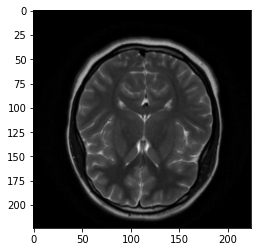

In [20]:
show_image(*dataset[0])

In [21]:
val_percent = 0.1
val_size = int(val_percent * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [22]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [23]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *img_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


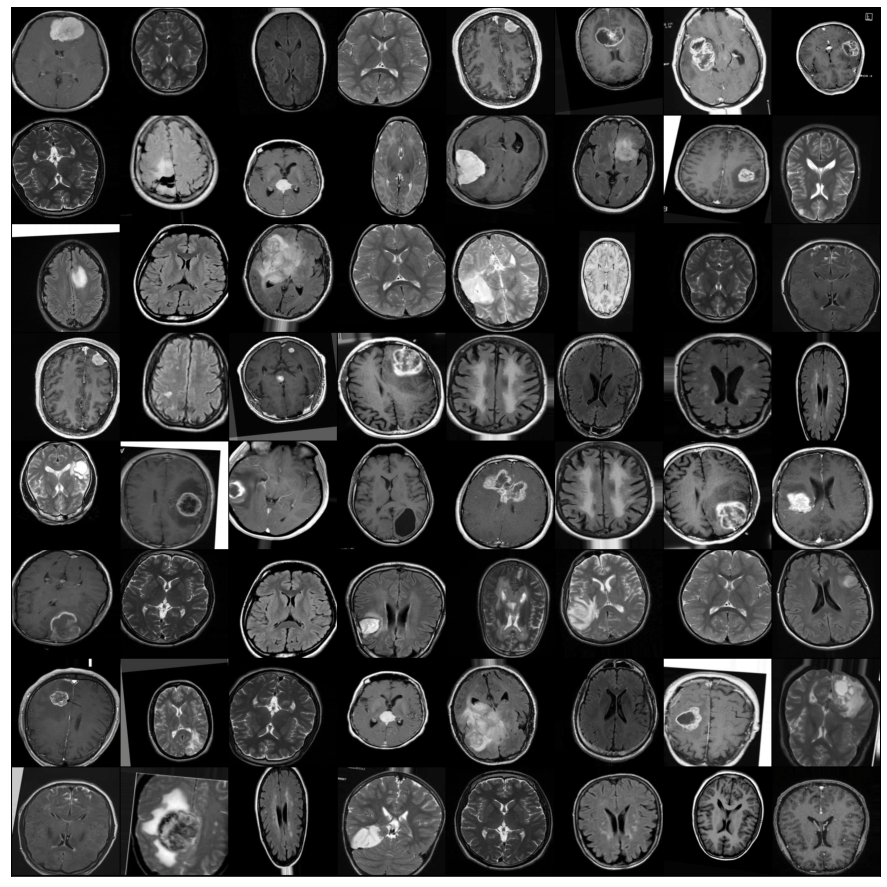

In [24]:
show_batch(train_dl)

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MRIClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                                                                        # Generate predictions
        loss = F.cross_entropy(out, labels)                                                         # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                                                                           # Generate predictions
        loss = F.cross_entropy(out, labels)                                                          # Calculate loss
        acc = accuracy(out, labels)                                                                  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()                                                # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()                                                   # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [26]:
models.vgg16().classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [27]:
class MRIModel(MRIClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg16(pretrained=pretrained)
        # Replace last layer
        self.network.classifier._modules['6'] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    def forward(self, xb):
        return self.network(xb)

In [28]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
device = get_default_device()
device

device(type='cuda')

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [32]:
model = MRIModel(len(dataset.classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [33]:
model.parameters

<bound method Module.parameters of MRIModel(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [34]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.4696428179740906, 'val_loss': 0.7129887938499451}]

In [35]:
# epochs = 10
# max_lr = 0.1
# grad_clip = 0.5
# weight_decay = 1e-4
# opt_func = torch.optim.Adam

In [36]:
# %%time
# history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
#                          grad_clip=grad_clip, 
#                          weight_decay=weight_decay, 
#                          opt_func=opt_func)

In [37]:
epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

In [38]:
%%time
history = fit(epochs, lr, model, train_dl, valid_dl, opt_func=opt_func)


Epoch [0], train_loss: 0.9277, val_loss: 0.4653, val_acc: 0.7821



Epoch [1], train_loss: 0.4855, val_loss: 0.3796, val_acc: 0.8116



Epoch [2], train_loss: 0.4160, val_loss: 0.2748, val_acc: 0.8687



Epoch [3], train_loss: 0.2721, val_loss: 0.4792, val_acc: 0.7953



Epoch [4], train_loss: 0.2068, val_loss: 0.1953, val_acc: 0.9060



Epoch [5], train_loss: 0.1707, val_loss: 0.2207, val_acc: 0.9259



Epoch [6], train_loss: 0.1246, val_loss: 0.1400, val_acc: 0.9400



Epoch [7], train_loss: 0.0541, val_loss: 0.0545, val_acc: 0.9808



Epoch [8], train_loss: 0.0365, val_loss: 0.0791, val_acc: 0.9761



Epoch [9], train_loss: 0.0456, val_loss: 0.0476, val_acc: 0.9871
CPU times: user 6min 26s, sys: 6min 16s, total: 12min 42s
Wall time: 13min 45s


In [41]:
# epochs = 10
# lr = 0.0005
# opt_func = torch.optim.Adam

In [42]:
# %%time
# history += fit(epochs, lr, model, train_dl, valid_dl, opt_func=opt_func)

In [43]:
train_time = str('13.45')

In [44]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

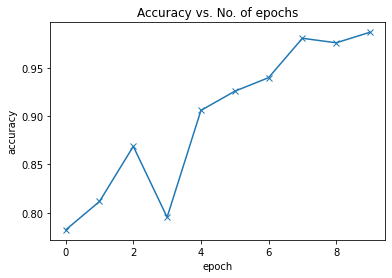

In [45]:
plot_accuracies(history)

In [46]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

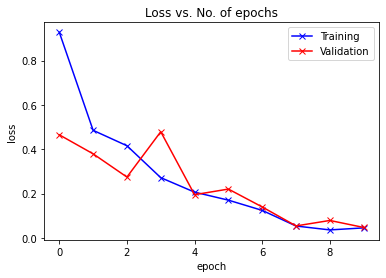

In [47]:
plot_losses(history)

In [48]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

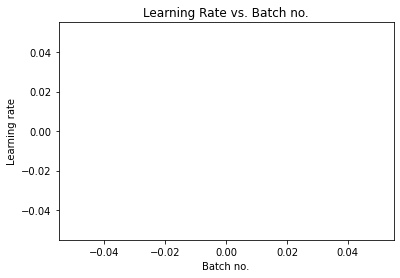

In [49]:
plot_lrs(history)

## Testing with individual images

In [50]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)     # Convert to a batch of 1
    yb = model(xb)                               # Get predictions from model
    _, preds  = torch.max(yb, dim=1)             # Pick index with highest probability
    return dataset.classes[preds[0].item()]      # Retrieve the class label

Label: yes , Predicted: yes


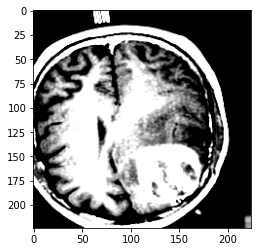

In [51]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: yes , Predicted: yes


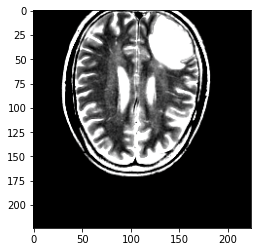

In [57]:
img, label = valid_ds[60]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: yes , Predicted: yes


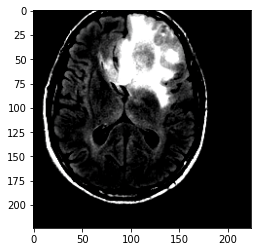

In [58]:
img, label = valid_ds[40]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: no , Predicted: no


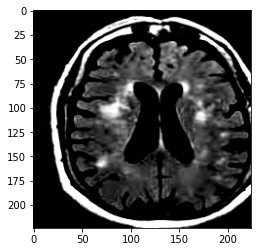

In [55]:
img, label = valid_ds[20]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

## Save and Commit


In [64]:
torch.save(model.state_dict(), 'VGG16-MRIModel.pth')

In [65]:
jovian.reset()
jovian.log_hyperparams(arch='VGG16-MRIModel.pth', 
                       epochs=epochs, 
                       lr=lr, 
                       scheduler='one-fit', 
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [66]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [69]:
# Save the project

jovian.commit(project='my-course-project-zerotogans', environment=None, outputs=['VGG16-MRIModel.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (VGG16-MRIModel.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/luciano-abatidaga/my-course-project-zerotogans


'https://jovian.ai/luciano-abatidaga/my-course-project-zerotogans'

## Conclusions

Throughout this project, I have made a deep learning model using Google Colaboratory GPU, pytorch as API and a network architecture based on VGG16. Different parameters and hyperparameters were tested.

In the future, it should be tested with other parameters and hyperparameters, another network architecture and perform techniques to avoid overfitting or unbalanced data.